# Prueba Coink - Cientifico de Datos
En este Jupyter Notebook se desarrollan los 3 puntos de la prueba Coink para el cargo Cientifico de Datos con fecha de entrega domingo 19 de marzo 2023. Además del enunciado, para la realizar la prueba se necesitan dos datasets que estan contenidos en el folder resources

In [8]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

### Punto 1
En este punto piden evaluar que tan buenos son los usuarios de Coink y calificar a los usuarios contenidos en la muestra **depositos_oink.csv**. Lo primero es cargar los datos para hacer una primera exploración

In [9]:
# Lee el .csv de resources. La primera columna (Unnamed: 0) son indices
depositos_oink_df = pd.read_csv("resources\depositos_oinks.csv", index_col = 'Unnamed: 0')

# Cast de las columnas que contienen fechas. Se hace para mejor operabilidad
# Convierte la fecha en un delta de tiempo igual al tiempo transcurrido desde la fechas hasta la actualidad
now = datetime.now()
for col in ['operation_date', 'user_createddate']:
    depositos_oink_df[col] = (now - pd.to_datetime(depositos_oink_df[col]))

depositos_oink_df.head(5)

,user_id,operation_value,operation_date,maplocation_name,user_createddate
0,0e52d550-ae23-407a-9b1f-6e5fb1f066ab,273850.0,426 days 09:13:08.265549,CC Plaza de las Américas - Plaza Mariposa,431 days 02:57:45.932860
1,975ed41e-d891-4c23-aeba-06363019d8e3,900.0,403 days 09:09:39.265549,CC Plaza de las Américas - Plaza Mariposa,430 days 07:01:34.846474
2,f9043545-dfc2-402f-a8c7-0a61f21cb719,1800.0,386 days 08:19:08.265549,Universidad de los Andes - ML Piso 5,568 days 09:36:15.740608
3,979ca8ad-9600-4a1f-81e9-e70c2f55cdc5,6500.0,455 days 10:11:19.265549,CC Plaza de las Américas - Plaza Mariposa,607 days 05:09:47.499258
4,171db06e-2e4b-4542-a9c9-32028520fda4,150000.0,415 days 10:20:46.265549,CC Plaza de las Américas - Plaza Mariposa,429 days 06:21:36.613555


La métrica para calificar usuarios (user_score) propuesta se describe a continuación.

$$user\_score = C_{monto}+C_{recurrencia}$$
$user score$ es la suma de dos coeficientes que miden aspectos distintos en la importancia del usuario. Por un lado $C_{recurrencia}$ cuantifica la recurrencia con la que la persona hace depositos. Adicional, $C_{monto}$ cuantifica el tamaño de los depositos.

Específicamente, $C_{recurrencia}$ se define como el tiempo promedio entre cada operación. La idea es que entre menor sea el tiempo promedio entre transacciones el usuario puntue más alto. Adicionalmente, se divide dicho promedio entre el tiempo de creación de la cuenta más vieja de la muestra. La división se hace para que $C_{recurrencia}$ quede en numeros adimensionales y se prioricen las personas más antiguas en caso de tiempos promedios entre transacciones similares.

In [10]:
## Agrupación del dataset por usuario

# Diccionario de agrupacion. Se extraen las siguientes variables
# - La primera y ultima fecha de transaccion
# - La fecha de creacion del usuario
# - El numero de transacciones
# - Monto total de las transferencias
agg_dict = {'operation_date': ['min', 'max'], 'user_createddate': 'first', \
            'user_id': 'count', 'operation_value' : 'sum'}

# Agrupacion por user_id
grouped_df = depositos_oink_df.groupby('user_id').agg(agg_dict)

grouped_df.head(5)

operation_date  \
                                                          min   
user_id                                                         
001762e3-094d-415c-9304-c7c182e0c16a 388 days 09:07:11.265549   
002a5f4d-a93d-4cc5-b089-e16169bc16a2 414 days 13:01:29.265549   
006687d3-8ff3-461e-bdac-cb8e8e4c5a26 456 days 02:15:50.265549   
0072157e-a634-4cb3-bead-b1a2981485ca 404 days 10:54:38.265549   
0082af19-8bf7-46f7-8a21-c34e46ac5e2a 397 days 03:27:17.265549   

                                                               \
                                                          max   
user_id                                                         
001762e3-094d-415c-9304-c7c182e0c16a 404 days 09:20:59.265549   
002a5f4d-a93d-4cc5-b089-e16169bc16a2 414 days 13:01:29.265549   
006687d3-8ff3-461e-bdac-cb8e8e4c5a26 456 days 03:43:17.265549   
0072157e-a634-4cb3-bead-b1a2981485ca 418 days 11:01:38.265549   
0082af19-8bf7-46f7-8a21-c34e46ac5e2a 397 days 03:27:17.265549   

                                             user_createddate user_id  \
                                                        first   count   
user_id                                                                 
001762e3-094d-415c-9304-c7c182e0c16a 493 days 10:14:28.718274       3   
002a5f4d-a93d-4cc5-b089-e16169bc16a2 477 days 13:57:07.863332       1   
006687d3-8ff3-461e-bdac-cb8e8e4c5a26 716 days 05:33:55.646962       4   
0072157e-a634-4cb3-bead-b1a2981485ca 427 days 11:31:15.564969      10   
0082af19-8bf7-46f7-8a21-c34e46ac5e2a 458 days 10:39:31.195762       1   

                                     operation_value  
                                                 sum  
user_id                                               
001762e3-094d-415c-9304-c7c182e0c16a         44750.0  
002a5f4d-a93d-4cc5-b089-e16169bc16a2        259000.0  
006687d3-8ff3-461e-bdac-cb8e8e4c5a26        375600.0  
0072157e-a634-4cb3-bead-b1a2981485ca        433450.0  
0082af19-8bf7-46f7-8a21-c34e46ac5e2a          1500.0


A continuación se calcula el $C_{recurrencia}$ de cada usuario. Como se menciono, está definido como:
$$
C_{recurrencia}=\frac{\hat{\Delta t}}{Tiempo\ de\ creación\ usuario}
$$
Donde $\hat{\Delta t}$ es el tiempo promedio entre transacciones que se puede calcular como
$$
\hat{\Delta t}=\frac{(t_1-t_2)+(t_2-t_3)+...+(t_{n-1}-t_n)}{número\ de\ transacciones}=\frac{t_1-t_n}{número\ de\ transacciones}
$$
Donde $t_i$ es la fecha de la transacción $i$

In [11]:
## Calculo de c_recurrencia
grouped_df['c_recurrencia'] = (grouped_df[('user_createddate', 'first')] - grouped_df[('operation_date', 'min')] \
    / grouped_df[('user_id', 'count')]) / grouped_df[('user_createddate', 'first')]

grouped_df.head()

operation_date  \
                                                          min   
user_id                                                         
001762e3-094d-415c-9304-c7c182e0c16a 388 days 09:07:11.265549   
002a5f4d-a93d-4cc5-b089-e16169bc16a2 414 days 13:01:29.265549   
006687d3-8ff3-461e-bdac-cb8e8e4c5a26 456 days 02:15:50.265549   
0072157e-a634-4cb3-bead-b1a2981485ca 404 days 10:54:38.265549   
0082af19-8bf7-46f7-8a21-c34e46ac5e2a 397 days 03:27:17.265549   

                                                               \
                                                          max   
user_id                                                         
001762e3-094d-415c-9304-c7c182e0c16a 404 days 09:20:59.265549   
002a5f4d-a93d-4cc5-b089-e16169bc16a2 414 days 13:01:29.265549   
006687d3-8ff3-461e-bdac-cb8e8e4c5a26 456 days 03:43:17.265549   
0072157e-a634-4cb3-bead-b1a2981485ca 418 days 11:01:38.265549   
0082af19-8bf7-46f7-8a21-c34e46ac5e2a 397 days 03:27:17.265549   

                                             user_createddate user_id  \
                                                        first   count   
user_id                                                                 
001762e3-094d-415c-9304-c7c182e0c16a 493 days 10:14:28.718274       3   
002a5f4d-a93d-4cc5-b089-e16169bc16a2 477 days 13:57:07.863332       1   
006687d3-8ff3-461e-bdac-cb8e8e4c5a26 716 days 05:33:55.646962       4   
0072157e-a634-4cb3-bead-b1a2981485ca 427 days 11:31:15.564969      10   
0082af19-8bf7-46f7-8a21-c34e46ac5e2a 458 days 10:39:31.195762       1   

                                     operation_value c_recurrencia  
                                                 sum                
user_id                                                             
001762e3-094d-415c-9304-c7c182e0c16a         44750.0      0.737631  
002a5f4d-a93d-4cc5-b089-e16169bc16a2        259000.0      0.131996  
006687d3-8ff3-461e-bdac-cb8e8e4c5a26        375600.0      0.840801  
0072157e-a634-4cb3-bead-b1a2981485ca        433450.0      0.905386  
0082af19-8bf7-46f7-8a21-c34e46ac5e2a          1500.0      0.133713

Para estimar $C_{monto}$, simplemente se divide el monto total transferido por el usuario entre el mayor monto total entre todos los usuarios. Esto se hace para que el coeficiente quede en valores adimensionales y se le asigne un puntaje más alto a los que tienen más dinero transferido. Sin embargo, en un país con ingresos tan desiguales no sería justo una métrica directamente proporcional al ingreso de la persona. Para ilustrar el problema se realiza la siguiente gráfica:


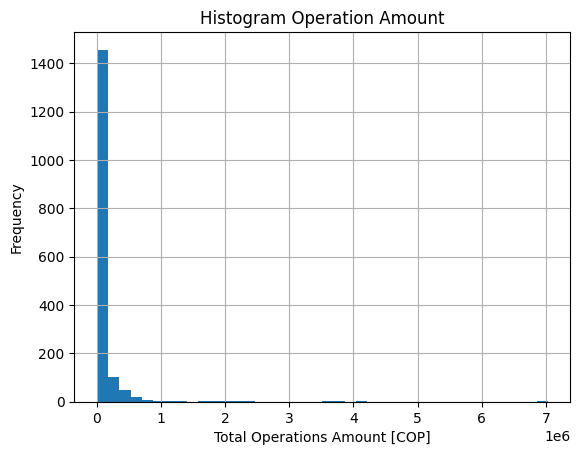

In [12]:
## Plot histograma del monto total de las transferencias de cada usuario
grouped_df[('operation_value', 'sum')].hist(bins = 40)

# Añade etiquetas y titulo
plt.xlabel('Total Operations Amount [COP]')
plt.ylabel('Frequency')
plt.title('Histogram Operation Amount')
plt.show()

Para corregir ese sesgo se opta por aplicar una transformación a la variable del monto total de las transferencias.

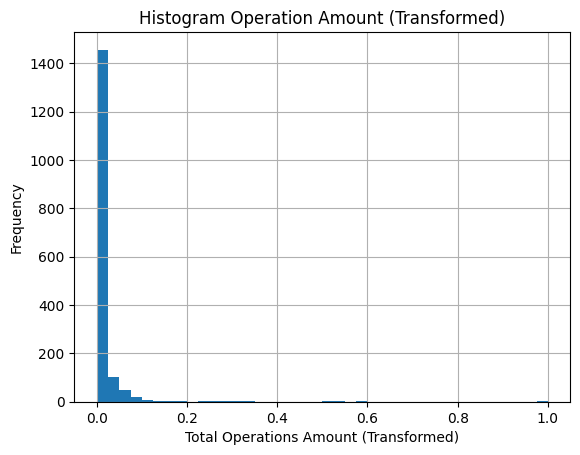

In [13]:
## Normalizacion y comprobacion de la misma

# Importacion y aplicacion de la funcion
from scipy.stats import boxcox
#grouped_df['operation_trans'], _ = boxcox(grouped_df[('operation_value', 'sum')])
grouped_df['operation_trans'] = (grouped_df[('operation_value', 'sum')] - grouped_df[('operation_value', 'sum')].min()) \
    / (grouped_df[('operation_value', 'sum')].max() - grouped_df[('operation_value', 'sum')].min())
# Plot histograma del monto total de las transferencias de cada usuario transformado
grouped_df['operation_trans'].hist(bins = 40)

# Añade etiquetas y titulo
plt.xlabel('Total Operations Amount (Transformed)')
plt.ylabel('Frequency')
plt.title('Histogram Operation Amount (Transformed)')
plt.show()

La distribucion de la variable creada no tiene el sesgo tan pronunciado de la anterior. Esta es la que se usa para el calculo de $C_{monto}$

In [14]:
grouped_df['c_monto'] = grouped_df['operation_trans'] / grouped_df['operation_trans'].max()


Por último, los numeros al lado de cada coeficiente son los peso. Para esta prueba se le da más importancia al número de transacciones realizadas que a los montos de las transacciones. Adicional, esto nos garantiza que $0<user score<=1$, siempre y cuando la suma de los pesos sea 1, ya que los coeficientes ya cumplen esta desigualdad

In [16]:
grouped_df['user_score'] = grouped_df['c_recurrencia'] + grouped_df['c_monto']

grouped_df.head()

operation_date  \
                                                          min   
user_id                                                         
001762e3-094d-415c-9304-c7c182e0c16a 388 days 09:07:11.265549   
002a5f4d-a93d-4cc5-b089-e16169bc16a2 414 days 13:01:29.265549   
006687d3-8ff3-461e-bdac-cb8e8e4c5a26 456 days 02:15:50.265549   
0072157e-a634-4cb3-bead-b1a2981485ca 404 days 10:54:38.265549   
0082af19-8bf7-46f7-8a21-c34e46ac5e2a 397 days 03:27:17.265549   

                                                               \
                                                          max   
user_id                                                         
001762e3-094d-415c-9304-c7c182e0c16a 404 days 09:20:59.265549   
002a5f4d-a93d-4cc5-b089-e16169bc16a2 414 days 13:01:29.265549   
006687d3-8ff3-461e-bdac-cb8e8e4c5a26 456 days 03:43:17.265549   
0072157e-a634-4cb3-bead-b1a2981485ca 418 days 11:01:38.265549   
0082af19-8bf7-46f7-8a21-c34e46ac5e2a 397 days 03:27:17.265549   

                                             user_createddate user_id  \
                                                        first   count   
user_id                                                                 
001762e3-094d-415c-9304-c7c182e0c16a 493 days 10:14:28.718274       3   
002a5f4d-a93d-4cc5-b089-e16169bc16a2 477 days 13:57:07.863332       1   
006687d3-8ff3-461e-bdac-cb8e8e4c5a26 716 days 05:33:55.646962       4   
0072157e-a634-4cb3-bead-b1a2981485ca 427 days 11:31:15.564969      10   
0082af19-8bf7-46f7-8a21-c34e46ac5e2a 458 days 10:39:31.195762       1   

                                     operation_value c_recurrencia  \
                                                 sum                 
user_id                                                              
001762e3-094d-415c-9304-c7c182e0c16a         44750.0      0.737631   
002a5f4d-a93d-4cc5-b089-e16169bc16a2        259000.0      0.131996   
006687d3-8ff3-461e-bdac-cb8e8e4c5a26        375600.0      0.840801   
0072157e-a634-4cb3-bead-b1a2981485ca        433450.0      0.905386   
0082af19-8bf7-46f7-8a21-c34e46ac5e2a          1500.0      0.133713   

                                     operation_trans   c_monto user_score  
                                                                           
user_id                                                                    
001762e3-094d-415c-9304-c7c182e0c16a        0.006356  0.006356   0.371994  
002a5f4d-a93d-4cc5-b089-e16169bc16a2        0.036822  0.036822   0.084409  
006687d3-8ff3-461e-bdac-cb8e8e4c5a26        0.053402  0.053402   0.447102  
0072157e-a634-4cb3-bead-b1a2981485ca        0.061629  0.061629   0.483507  
0082af19-8bf7-46f7-8a21-c34e46ac5e2a        0.000206  0.000206   0.066960

### Punto 2
En el punto 2 piden explicar en 300 palabras o menos como se haría el depliegue de un modelo de ML en AWS. Este debe ser ejecutado a demanda con un API.

### Punto 3
En el punto 3 entrenar 2 modelos de apredizaje supervisado para predicir la variable JobSatisfaction del dataset info_satisfaccion_trabajo.xlsx. Adicionalmente, explicar en 150 palabras o menos como monitorear el modelo en caso de que estuviera desplegado para uso recurrente.

Primero se cargan los datos para un analisis preliminar

In [ ]:
satisfaction_df = pd.read_excel("resources\info_satisfaccion_trabajo.xlsx")
satisfaction_df = satisfaction_df.drop(columns=['EmployeeCount', 'Over18', 'StandardHours'])
satisfaction_df.head(5)

Al observar el dataset se observan variables que no aportan ningun valor para predecir ya que son constantes, estas se eliminan de inmediato. Adicionalmente se observan que el dataset contiene varios tipos de datos. Para poder entrenar un modelo es necesario transformar el dataset. Para este procedimiento se define la funcion `encoder()`

In [57]:
def encoder(df):
    '''
        Transforma un dataframe. Aplica la debida codificacion a las variables categoricas y 
        estandariza las variables numericas.
        Args:
        - df (pd.DataFrame): dataframe a transformar
        Returns:
        - df_encoded (np.array) : dataframe transformado
    '''
    from sklearn.compose import ColumnTransformer
    from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

    # Identificacion del tipo de transformacion que se le debe hacer a cada columna
    onehot_cols = []
    ordinal_cols = []
    scaling_cols = []
    for col in df.columns:
        columna = df[col]
        if col == 'TrainingTimesLastYear':
            scaling_cols.append(col)
            continue
        if df[col].dtype == 'object':
            onehot_cols.append(col)
        elif len(columna.unique()) <= 8:
            ordinal_cols.append(col)
        else:
            scaling_cols.append(col)
    

    # Se crea un objeto ColumnTransformer con las columnas ya clasificadas segun transformacion
    ct = ColumnTransformer(transformers = [('onehot', OneHotEncoder(), onehot_cols), 
                                           ('cardinal', OrdinalEncoder(), ordinal_cols),
                                           ('scaling', StandardScaler(), scaling_cols)],
                                           remainder='passthrough')

    # Aplica la transformacion al dataframe
    df_encoded = ct.fit_transform(df)

    return df_encoded

In [ ]:
def random_forest(df):

    from sklearn.model_selection import GridSearchCV, train_test_split
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
    from sklearn.preprocessing import OrdinalEncoder

    variable_pred = 'JobSatisfaction'

    X = df.drop(variable_pred, axis=1)
    y = df[variable_pred]

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

    X_train = encoder(X_train)
    X_test = encoder(X_test)

    ord_encoder = OrdinalEncoder()
    y_train = ord_encoder.fit_transform(y_train.values.reshape(-1, 1))
    y_test = ord_encoder.fit_transform(y_test.values.reshape(-1, 1))

    
    param_grid = {'max_features' : [30, 10, 20, X_train.shape[1]],
                  'n_estimators' : [100, 500, 750, 1500, 3000, 5000]}
    grid = GridSearchCV(RandomForestClassifier(), param_grid, n_jobs = -1, error_score="raise")
    grid.fit(X_train, y_train)

    print('Grid best params: ', grid.best_params_)
    print('Grid best score: ', grid.best_score_)

    y_pred = grid.predict(X_test)

    print('Accuracy', accuracy_score(y_test, y_pred))
    print('F1', f1_score(y_test, y_pred))
    print('MAPE', roc_auc_score(y_test, y_pred))


    return

In [ ]:
vic, victest = random_forest(satisfaction_df)

In [ ]:
def gradientBoostingClassifier(df):

    from sklearn.model_selection import GridSearchCV, train_test_split
    from sklearn.ensemble import GradientBoostingClassifier
    from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
    from sklearn.preprocessing import OrdinalEncoder

    variable_pred = 'JobSatisfaction'

    X = df.drop(variable_pred, axis=1)
    y = df[variable_pred]

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

    X_train = encoder(X_train)
    X_test = encoder(X_test)

    ord_encoder = OrdinalEncoder()
    y_train = ord_encoder.fit_transform(y_train.values.reshape(-1, 1))
    y_test = ord_encoder.fit_transform(y_test.values.reshape(-1, 1))

    
    param_grid = {'learning_rate' : [0, 0.001, 0.01, 0.1, 1, 0.00001],
                  'n_estimators' : [10, 100, 500, 600, 700]}
    grid = GridSearchCV(GradientBoostingClassifier(), param_grid, n_jobs = -1, error_score="raise")
    grid.fit(X_train, y_train)

    print('Grid best params: ', grid.best_params_)
    print('Grid best score: ', grid.best_score_)

    y_pred = grid.predict(X_test)

    print('Accuracy', accuracy_score(y_test, y_pred))
    print('F1', f1_score(y_test, y_pred))
    print('MAPE', roc_auc_score(y_test, y_pred))


    return

In [ ]:
gradientBoostingClassifier(satisfaction_df)

In [66]:
def neural_network(df):
    """
        Entrena un red neuronal a partir de un dataframe
        Args:
        - df (pd.DataFrame) : dataset principal
    """

    from sklearn.model_selection import GridSearchCV, train_test_split
    from sklearn.neural_network import MLPClassifier
    from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
    from sklearn.preprocessing import OrdinalEncoder

    # Se especifica la variable a predecir y se separa del resto del dataset
    variable_pred = 'JobSatisfaction'
    X = df.drop(variable_pred, axis=1)
    y = df[variable_pred]

    # Separacion de los datos para entrenar y para testear
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

    # Preprocesamiento de los datos
    X_train = encoder(X_train)
    X_test = encoder(X_test)
    ord_encoder = OrdinalEncoder()
    y_train = ord_encoder.fit_transform(y_train.values.reshape(-1, 1))
    y_test = ord_encoder.fit_transform(y_test.values.reshape(-1, 1))

    # Creacion de un objeto Grid para optimizacion de hiperparametros
    param_grid = {
        'hidden_layer_sizes': [(50, 50, 50), (50, 50), (1000,)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'sgd'],
        'learning_rate_init': [0.001, 0.01, 0.1, 1, 10],
        'max_iter': [3000, 5000, 8000],
        'random_state' : [0]
    }
    grid = GridSearchCV(MLPClassifier(), param_grid, n_jobs = -1, error_score="raise")

    # Entrenamiento del modelo
    grid.fit(X_train, y_train)

    # Prediccion del modelo con los datos de testeo
    y_pred = grid.predict(X_test)

    # Metricas
    print('Grid best params: ', grid.best_params_)
    print('Grid best score: ', grid.best_score_)
    print('Accuracy', accuracy_score(y_test, y_pred))
    print('F1', f1_score(y_test, y_pred))
    print('MAPE', roc_auc_score(y_test, y_pred))

    return

In [67]:
neural_network(satisfaction_df)

C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1096: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Grid best params:  {'activation': 'tanh', 'hidden_layer_sizes': (50, 50, 50), 'learning_rate_init': 1, 'max_iter': 3000, 'random_state': 0, 'solver': 'sgd'}
Grid best score:  0.3094446729740848
